# Double Cartpole



The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta_1 & \dot{\theta_1} & \theta_2 & \dot{\theta_2}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the carptole upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0 & 0 & 0
    \end{bmatrix}
\end{equation*}
$$

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.05  # Time step (s).
RENDER = True  # Whether to render the environment or not.
N = 50 # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.double_cartpole.DoubleCartpoleCost()
model = pddp.examples.double_cartpole.DoubleCartpoleDynamicsModel(DT)
env = pddp.examples.double_cartpole.DoubleCartpoleEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = U.detach().numpy()

    x = X[:, 0]
    x_dot = X[:, 1]
    theta1 = np.unwrap(X[:, 2])  # Makes for smoother plots.
    theta1_dot = X[:, 3]
    theta2 = np.unwrap(X[:, 4])  # Makes for smoother plots.
    theta2_dot = X[:, 5]
    
    plt.figure()
    plt.plot(theta1, theta1_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 1 Orientation Phase Plot")

    plt.figure()
    plt.plot(theta2, theta2_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Link 2 Orientation Phase Plot")
    
    plt.figure()
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Position (m)")
    plt.title("Position path")
    
    plt.figure()
    plt.plot(t, x_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Velocity (m / s)")
    plt.title("Velocity path")
    
    plt.figure()
    plt.plot(t, theta1)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 1 orientation path")

    plt.figure()
    plt.plot(t, theta1_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 1 angular velocity path")
    
    plt.figure()
    plt.plot(t, theta2)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Link 2 orientation path")
    
    plt.figure()
    plt.plot(t, theta2_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Link 2 angular velocity path")

    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Force (N)")
    plt.title("Action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[2] = (final_state[2] + np.pi) % (2 * np.pi) - np.pi
    final_state[4] = (final_state[4] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = 1e-1 * torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, tol=0,
                      on_iteration=on_iteration)

iteration 7 accepted 1088.116 [ 0.03173758  0.01353203 -3.1332436  -0.00515661  3.1132548  -0.01222263]
iteration 8 accepted 1087.9276 [ 1.2932614e-02  1.0166895e-03 -3.1336737e+00 -1.4428273e-03
  3.1049621e+00 -3.5696179e-03]
iteration 9 accepted 1080.5328 [-2.9162848e-03  5.5730678e-03  3.1112201e+00  2.5044411e-02
  2.8653512e+00 -5.1290154e-02]
iteration 12 accepted 1055.835 [-0.00558384  0.01941036  3.0388145   0.06923285  2.5276914  -0.2346896 ]
iteration 14 accepted 1018.64606 [ 2.1515943e-03  3.9709710e-02  2.9450448e+00  4.4611387e-02
  2.1965587e+00 -4.2933273e-01]
iteration 15 FAILED 1018.64606 [ 2.1515943e-03  3.9709710e-02  2.9450448e+00  4.4611387e-02
  2.1965587e+00 -4.2933273e-01]
iteration 16 accepted 963.08167 [ 0.02880817  0.06903815  2.7954767  -0.08892179  1.7479218  -0.7284732 ]
iteration 17 accepted 901.99316 [ 0.05604198  0.10302617  2.6229842  -0.1999762   1.4322897  -0.811965  ]
iteration 19 accepted 828.0459 [ 0.08284779  0.023757    2.0200317  -0.9823767   

iteration 89 accepted 322.15518 [-0.00810175  0.01418573  0.37813115 -0.14128733 -0.02741366  0.03293446]
iteration 90 accepted 322.0979 [-0.00606687  0.01266813  0.3778835  -0.14074898 -0.02755253  0.03420761]
iteration 91 accepted 321.92548 [-0.00539945  0.00338298  0.36982355 -0.13491893 -0.01690591  0.03363514]
iteration 92 accepted 321.87134 [-0.00385993  0.00358593  0.37188083 -0.13548112 -0.01579005  0.0340656 ]
iteration 93 accepted 321.85522 [-0.00402787  0.00328642  0.37249574 -0.13535261 -0.01377868  0.03425872]
iteration 94 accepted 321.84518 [-0.00413238  0.00267661  0.37201536 -0.13493657 -0.01314972  0.03459996]
iteration 95 accepted 321.82404 [-0.00516579  0.00185645  0.37163925 -0.13424039 -0.0096334   0.03456384]
iteration 96 accepted 321.81668 [-0.00515784  0.00152057  0.37131196 -0.13400888 -0.00942868  0.03475893]
iteration 97 accepted 321.80646 [-5.9150243e-03  1.9675493e-04  3.6980185e-01 -1.3291550e-01
 -6.9895838e-03  3.5136521e-02]
iteration 98 accepted 321.79

/Users/anass/Dev/personal/pddp/pddp/controllers/ilqr.py:241: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


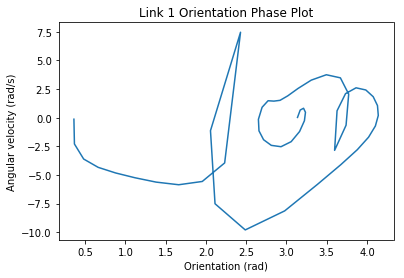

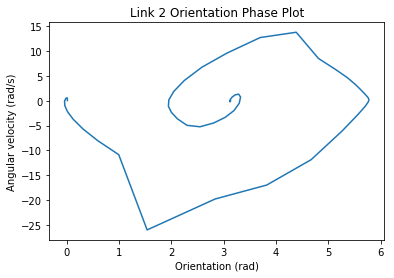

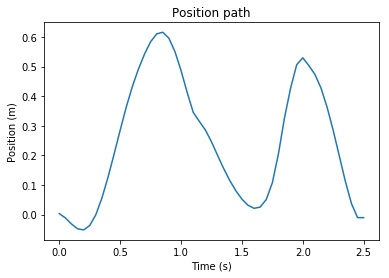

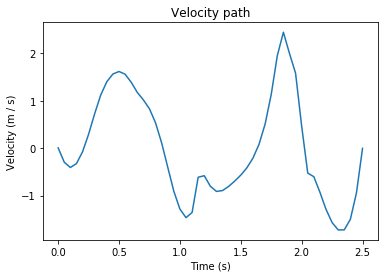

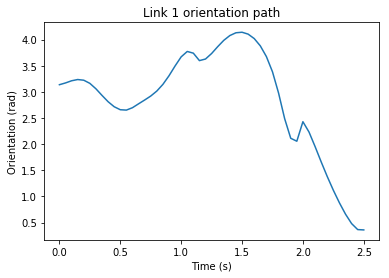

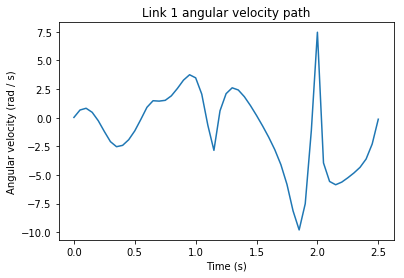

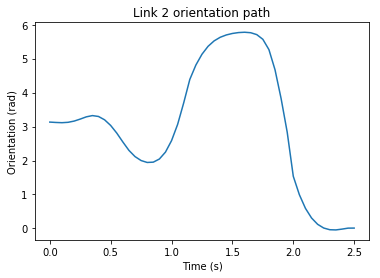

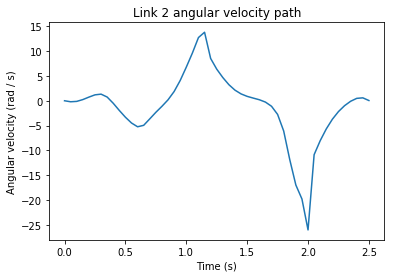

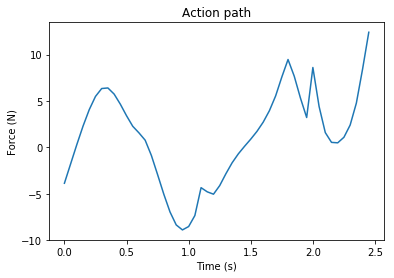

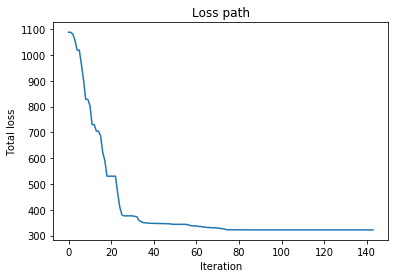

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
env.reset()
for i in range(N):
    z = env.get_state().encode(ENCODING)
    u = controller(z, i, ENCODING)
    env.apply(u)

In [16]:
env.close()